# Advanced: Recovering the 12-6 Lennard-Jones Potential

This tutorial expands upon the previous 12-6 LJ tutorial.  Here, we will attempt to recover not only epsilon and sigma, but also the two exponents.

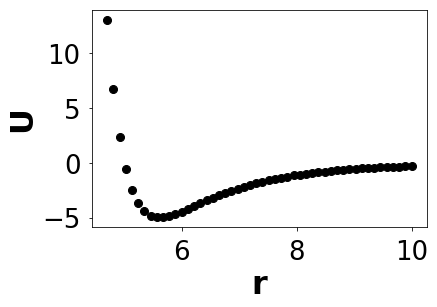

In [90]:
import numpy as np

from nanoparticle_optimization.forcefield import Mie, Parameter
from nanoparticle_optimization.target import Target

sigma_target = Parameter(value=5.0, fixed=True)
epsilon_target = Parameter(value=5.0, fixed=True)
n_target = Parameter(value=12.0, fixed=True)
m_target = Parameter(value=6.0, fixed=True)

mie_target = Mie(sigma=sigma_target, epsilon=epsilon_target, n=n_target, m=m_target)

sep_low = np.linspace(4.7, 5.7, 50)[:-1]
sep_hi = np.linspace(5.7, 10, 50)
separations = np.hstack((sep_low, sep_hi))
target = Target(separations=separations, potential=potential)

separations = np.linspace(4.7, 10.0, 50)
potential = np.array([mie_target.calc_potential(r) for r in separations])
target2 = Target(separations=separations, potential=potential)

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(separations, potential, linestyle='None', marker='o', color='black')
plt.xlabel('r')
plt.ylabel('U')

As in the previous tutorial we create a target potential of the 12-6 LJ form with sigma and epsilon values of 5.0.

In [91]:
import mbuild as mb

from nanoparticle_optimization.system import System

point_particle = mb.Compound(pos=np.zeros(3))
system = System(point_particle)

sigma = Parameter(value=2.5, upper=10.0, lower=2.0)
epsilon = Parameter(value=9.0, upper=10.0, lower=2.0)
n = Parameter(value=15.0, upper=25.0, lower=10.0)
m = Parameter(value=4.0, upper=10.0, lower=2.0)
ff = Mie(sigma=sigma, epsilon=epsilon, n=n, m=m)

Again we define the `Forcefield` that we want to optimize.  However this time we are not setting `n` and `m` to be fixed.

In [92]:
from nanoparticle_optimization.optimization import Optimization

optimization = Optimization(ff, system, target, configurations=1, verbose=True)
optimization.driver()

##############################################
Setup: Checking root problem for potential issues...

No recorders have been specified, so no data will be saved.

Setup: Check of root problem complete.
##############################################

Current values:
epsilon:	9.0
m:	4.0
n:	15.0
sigma:	2.5
Residual:	0.7611631554941903

Current values:
epsilon:	9.0
m:	4.0
n:	15.0
sigma:	2.5
Residual:	0.7611631554941903

Current values:
epsilon:	18.0
m:	4.0
n:	15.0
sigma:	2.5
Residual:	0.611207294611403

Current values:
epsilon:	18.0
m:	8.0
n:	15.0
sigma:	2.5
Residual:	0.9536655958929351

Current values:
epsilon:	18.0
m:	4.0
n:	30.0
sigma:	2.5
Residual:	0.688781835630081

Current values:
epsilon:	18.0
m:	4.0
n:	15.0
sigma:	5.0
Residual:	0.591069119798373

Current values:
epsilon:	21.529802309881926
m:	0.417286183679356
n:	11.95662896553059
sigma:	5.131675369067068
Residual:	0.7115472990893456

Current values:
epsilon:	13.702608811627405
m:	3.422243799868846
n:	14.509219386584993
sigma:	5.021

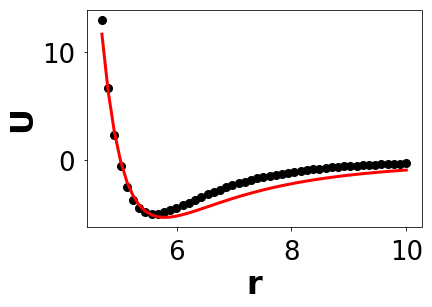

In [93]:
matched_potential = np.array([optimization.forcefield.calc_potential(r) for r in separations])

plt.plot(separations, potential, linestyle='None', marker='o', color='black')
plt.plot(separations, matched_potential, marker='None', color='red')
plt.xlabel('r')
plt.ylabel('U')

As we can see from the plot above, the optimization did a pretty poor job when optimizing all four parameters at once.  However, the value of `sigma` was optimizated correctly.  Here we have demonstrated the need for two optimizations.  One where all four parameters are allowed to change and the value of `sigma` is optimized, and a second where sigma is fixed at the optimized value and the remaining three values are allowed to change.

In [94]:
optimization.forcefield.sigma.fixed = True

second_optimization = Optimization(optimization.forcefield, system, target2, configurations=1, verbose=True)
second_optimization.driver()

##############################################
Setup: Checking root problem for potential issues...

No recorders have been specified, so no data will be saved.

Setup: Check of root problem complete.
##############################################

Current values:
epsilon:	5.3370192905818525
m:	3.974481565751377
n:	11.262057024449838
Residual:	0.1570456204193195

Current values:
epsilon:	5.3370192905818525
m:	3.974481565751377
n:	11.262057024449838
Residual:	0.1570456204193195

Current values:
epsilon:	10.674038581163705
m:	3.974481565751377
n:	11.262057024449838
Residual:	0.44778200043847477

Current values:
epsilon:	5.3370192905818525
m:	7.948963131502754
n:	11.262057024449838
Residual:	0.08195934735634879

Current values:
epsilon:	5.3370192905818525
m:	7.948963131502754
n:	22.524114048899676
Residual:	0.32095185105730717

Current values:
epsilon:	1.2938509048051456
m:	8.726578281117712
n:	4.248704349040208
Residual:	0.5102447166827554

Current values:
epsilon:	7.878072059426303
m:	8

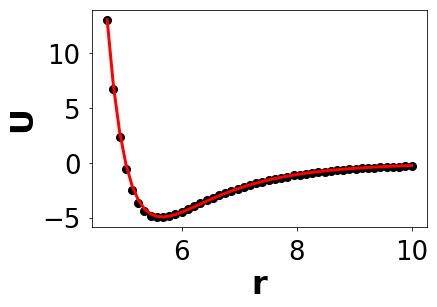

In [95]:
matched_potential = np.array([second_optimization.forcefield.calc_potential(r) for r in separations])

plt.plot(separations, potential, linestyle='None', marker='o', color='black')
plt.plot(separations, matched_potential, marker='None', color='red')
plt.xlabel('r')
plt.ylabel('U')

The plot above shows a definite improvement over the results from the first optimization.  Although the exponents do not match what we were expecting, we are able to achieve a very good fit (97%).  This demonstrates that the optimization will not always settle into the desired global minimum, but may locate a local minimum that provides a reasonable fit to the target data.  In the context of coarse-graining, this should still yield us a good force field.